In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import PolynomialFeatures

from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('../data/transform/transformed_data.csv')

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3040 entries, 0 to 3039
Data columns (total 49 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   match_api_id                  3040 non-null   int64  
 1   season                        3040 non-null   object 
 2   stage                         3040 non-null   int64  
 3   date                          3040 non-null   object 
 4   away_team                     3040 non-null   int64  
 5   home_team                     3040 non-null   int64  
 6   home_team_goal                3040 non-null   int64  
 7   away_team_goal                3040 non-null   int64  
 8   result_match                  3040 non-null   int64  
 9   away_possession               3040 non-null   int64  
 10  home_shoton                   3040 non-null   int64  
 11  home_possession               3040 non-null   int64  
 12  away_shoton                   3040 non-null   int64  
 13  pla

In [3]:
cols_to_remove = ['date', 'home_team_goal', 'away_team_goal', 'result_match', 'away_possession', 'home_possession', 'home_shoton', 'away_shoton']
df[['season']] = df[['season']].astype('category')

In [4]:
# Splitting the original dataset
X = df.drop(cols_to_remove, axis=1)
y = df['result_match']
X_train_full, X_test_full, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Initialize the XGBClassifier
xgb_full = XGBClassifier(random_state=42, enable_categorical=True)

# Train the model on the full feature set
xgb_full.fit(X_train_full, y_train)

# Predictions and evaluation on the full feature set
y_pred_full = xgb_full.predict(X_test_full)
accuracy_full = accuracy_score(y_test, y_pred_full)

print(f'Base line accuracy: {accuracy_full}')

Base line accuracy: 0.48026315789473684


In [5]:
cols_to_remove = ['match_api_id', 'stage']
df_numerical = df.select_dtypes(exclude='category').drop(cols_to_remove, axis=1)
df_numerical.to_csv('../data/transform/df_numerical.csv')
df_numerical.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3040 entries, 0 to 3039
Data columns (total 46 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   date                          3040 non-null   object 
 1   away_team                     3040 non-null   int64  
 2   home_team                     3040 non-null   int64  
 3   home_team_goal                3040 non-null   int64  
 4   away_team_goal                3040 non-null   int64  
 5   result_match                  3040 non-null   int64  
 6   away_possession               3040 non-null   int64  
 7   home_shoton                   3040 non-null   int64  
 8   home_possession               3040 non-null   int64  
 9   away_shoton                   3040 non-null   int64  
 10  player_rating_home_player_1   3040 non-null   int64  
 11  player_rating_home_player_2   3040 non-null   int64  
 12  player_rating_home_player_3   3040 non-null   int64  
 13  pla

In [6]:
def remove_highly_correlated_features(df, threshold=0.9, cols_to_remove=['date', 'away_team', 'home_team','home_team_goal',]):
    """
    Removes features from the dataframe that have a correlation coefficient
    higher than the specified threshold.

    Parameters:
    df (pd.DataFrame): Dataframe with numerical features.
    threshold (float): Threshold for high correlation.

    Returns:
    tuple: (set of features to remove, reduced dataframe shape)
    """
    # Calculate the correlation matrix
    correlation_matrix = df.drop(cols_to_remove, axis=1).corr()

    # Find feature pairs with correlation greater than the threshold
    # Interested in absolute value of correlation coefficient
    highly_correlated_pairs = correlation_matrix.abs().unstack().sort_values(ascending=False)
    highly_correlated_pairs = highly_correlated_pairs[highly_correlated_pairs >= threshold]
    highly_correlated_pairs = highly_correlated_pairs[highly_correlated_pairs < 1]  # Remove self-correlation

    # Since correlation is symmetric, we'll take one of each pair
    # We will only take the first of the pair to remove.
    features_to_remove = set([pair[0] for pair in highly_correlated_pairs.index])

    print(features_to_remove)
    df_ = df.drop(columns=features_to_remove)
    print(df_.shape)
    
    return df_

data_reduced = remove_highly_correlated_features(df_numerical)

{'player_rating_away_player_5', 'player_rating_away_player_2', 'player_rating_home_player_1', 'player_rating_home_player_3', 'player_rating_away_player_3', 'player_rating_home_player_2', 'player_rating_home_player_4', 'player_rating_away_player_4', 'player_rating_home_player_5', 'player_rating_away_player_1', 'avg_away_team_rating', 'player_rating_home_player_6', 'avg_home_team_rating', 'player_rating_away_player_6'}
(3040, 32)


In [7]:
# Splitting the original dataset
X = df_numerical.drop(['result_match', 'date', 'away_team', 'away_team_goal', 'home_team','home_team_goal', 'away_possession', 'home_shoton', 'home_possession', 'away_shoton', ], axis=1)
y = df_numerical['result_match']
X_train_full, X_test_full, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Initialize the XGBClassifier
xgb_full = XGBClassifier(random_state=42)

# Train the model on the full feature set
xgb_full.fit(X_train_full, y_train)

# Predictions and evaluation on the full feature set
y_pred_full = xgb_full.predict(X_test_full)
accuracy_full = accuracy_score(y_test, y_pred_full)

accuracy_full

0.4934210526315789

In [8]:
df_numerical.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3040 entries, 0 to 3039
Data columns (total 46 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   date                          3040 non-null   object 
 1   away_team                     3040 non-null   int64  
 2   home_team                     3040 non-null   int64  
 3   home_team_goal                3040 non-null   int64  
 4   away_team_goal                3040 non-null   int64  
 5   result_match                  3040 non-null   int64  
 6   away_possession               3040 non-null   int64  
 7   home_shoton                   3040 non-null   int64  
 8   home_possession               3040 non-null   int64  
 9   away_shoton                   3040 non-null   int64  
 10  player_rating_home_player_1   3040 non-null   int64  
 11  player_rating_home_player_2   3040 non-null   int64  
 12  player_rating_home_player_3   3040 non-null   int64  
 13  pla

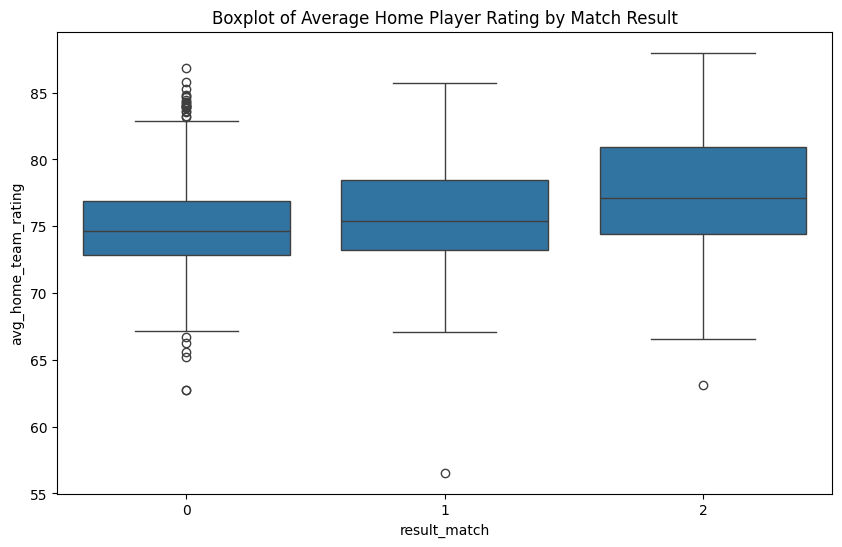

In [9]:
# Boxplot for 'avg_player_rating_home' vs 'result_match'
plt.figure(figsize=(10, 6))
sns.boxplot(x='result_match', y='avg_home_team_rating', data=df_numerical)
plt.title('Boxplot of Average Home Player Rating by Match Result')
plt.show()

In [10]:
# Clear negative correaltion between result_match and avg_palyer_rating_away

In [11]:
# List of player positions for which we have ratings
player_positions = range(1, 12)

# Calculate the difference from the average for each player
for position in player_positions:
    home_player_col = f'player_rating_home_player_{position}'
    away_player_col = f'player_rating_away_player_{position}'
    
    # Create new features for home and away players
    df_numerical[f'diff_player_{position}'] = df_numerical[home_player_col] - df_numerical[away_player_col]
    # data_reduced.drop([home_player_col, away_player_col], axis=1, inplace=True)

# Display the dataframe to confirm the new features
df_numerical.filter(like='diff_player').columns

Index(['diff_player_1', 'diff_player_2', 'diff_player_3', 'diff_player_4',
       'diff_player_5', 'diff_player_6', 'diff_player_7', 'diff_player_8',
       'diff_player_9', 'diff_player_10', 'diff_player_11'],
      dtype='object')

In [12]:
def calculate_rolling_averages(rolling_window_size, df, stat_columns):
    """
    Calculate rolling averages for various statistics without including the current match.

    Args:
    - rolling_window_size (int): Number of previous matches to include in the rolling average.
    - df (pd.DataFrame): The DataFrame containing the match data.
    - stat_columns (dict): A dictionary with keys for each stat category (e.g., 'goals', 'possession', 'shots_on'),
                           and values being another dictionary with 'home' and 'away' keys mapping to the respective columns.

    Returns:
    - pd.DataFrame: The DataFrame with new rolling average columns added.
    """

    # Iterate through each stat category
    for stat, columns in stat_columns.items():
        # Define new feature names for rolling features
        home_feature_name = f'home_{stat}_rolling'
        away_feature_name = f'away_{stat}_rolling'

        # Calculate rolling averages for home and away statistics
        for team_type in ['home', 'away']:
            # Sort by team and date
            df.sort_values(by=[f'{team_type}_team', 'date'], ascending=True, inplace=True)
            
            # Calculate rolling averages for the given stat
            df[home_feature_name if team_type == 'home' else away_feature_name] = (
                df.groupby(f'{team_type}_team')[columns[team_type]]
                .apply(lambda x: x.shift().rolling(window=rolling_window_size).mean())
                .reset_index(level=0, drop=True)
            )
            
            # Calculate the means for rolling features
            rolling_means = df.groupby(f'{team_type}_team')[home_feature_name if team_type == 'home' else away_feature_name].transform('mean')
            
            # Fill NaN values in rolling features with the team-specific means
            df[home_feature_name if team_type == 'home' else away_feature_name] = (
                df[home_feature_name if team_type == 'home' else away_feature_name].fillna(rolling_means)
            )

    return df

In [13]:
# Define a range of window sizes to test
window_sizes = [2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 15]

# Define your statistical categories and their corresponding columns
stat_columns = {
    'goals': {
        'home': 'home_team_goal',
        'away': 'away_team_goal'
    },
    'shots_on': {
        'home': 'home_shoton',
        'away': 'away_shoton'
    }
}

# Placeholder for best score and corresponding window size
best_score = -float('inf')
best_window_size = None

# Iterate over window sizes to find the best one
for window_size in window_sizes:
    # Calculate rolling averages using the current window size
    df_with_rolling = calculate_rolling_averages(window_size, df_numerical.copy(), stat_columns)

    df_with_rolling = df_with_rolling.drop(['date', 'away_team', 'away_team_goal', 'home_team','home_team_goal', 'away_possession', 'home_shoton', 'home_possession', 'away_shoton'], axis=1)
    
    # Extract features and target for model training
    X = df_with_rolling.drop(['result_match'], axis=1)
    y = df_with_rolling['result_match']
    
    # Define your model
    model = XGBClassifier(random_state=42)
    
    # Perform cross-validation
    scores = cross_val_score(model, X, y, cv=2, scoring='accuracy')
    
    # Calculate the mean score
    mean_score = scores.mean()
    
    # Update best score and window size if current score is better
    if mean_score > best_score:
        best_score = mean_score
        best_window_size = window_size

# best_window_size now holds the size of the window that gave the best performance
print(f"Best window size: {best_window_size} with score: {best_score}")

Best window size: 9 with score: 0.4756578947368421


In [14]:
df_with_rolling = calculate_rolling_averages(best_window_size, df=df_numerical.copy(), stat_columns=stat_columns)
df_with_rolling = df_with_rolling.drop(['date', 'away_team', 'away_team_goal', 'home_team','home_team_goal', 'away_possession', 'home_shoton', 'home_possession', 'away_shoton'], axis=1)

In [15]:
# Splitting the original dataset
X = df_with_rolling.drop('result_match', axis=1)
y = df_with_rolling['result_match']
X_train_full, X_test_full, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the XGBClassifier
xgb_full = XGBClassifier(random_state=42)

# Train the model on the full feature set
xgb_full.fit(X_train_full, y_train)

# Predictions and evaluation on the full feature set
y_pred_full = xgb_full.predict(X_test_full)
accuracy_full = accuracy_score(y_test, y_pred_full)

accuracy_full

0.4769736842105263

In [16]:
df_with_rolling.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3040 entries, 386 to 3016
Data columns (total 52 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   result_match                  3040 non-null   int64  
 1   player_rating_home_player_1   3040 non-null   int64  
 2   player_rating_home_player_2   3040 non-null   int64  
 3   player_rating_home_player_3   3040 non-null   int64  
 4   player_rating_home_player_4   3040 non-null   int64  
 5   player_rating_home_player_5   3040 non-null   int64  
 6   player_rating_home_player_6   3040 non-null   int64  
 7   player_rating_home_player_7   3040 non-null   int64  
 8   player_rating_home_player_8   3040 non-null   int64  
 9   player_rating_home_player_9   3040 non-null   int64  
 10  player_rating_home_player_10  3040 non-null   int64  
 11  player_rating_home_player_11  3040 non-null   int64  
 12  player_rating_away_player_1   3040 non-null   int64  
 13  player

In [17]:
# Positive correlations are shown by bars extending above the horizontal line (y=0), 
# indicating that an increase in these features is associated with higher values of 'result_match'.

# Negative correlations, shown by bars below the line, 
# suggest that an increase in these features is associated with lower values of 'result_match'.

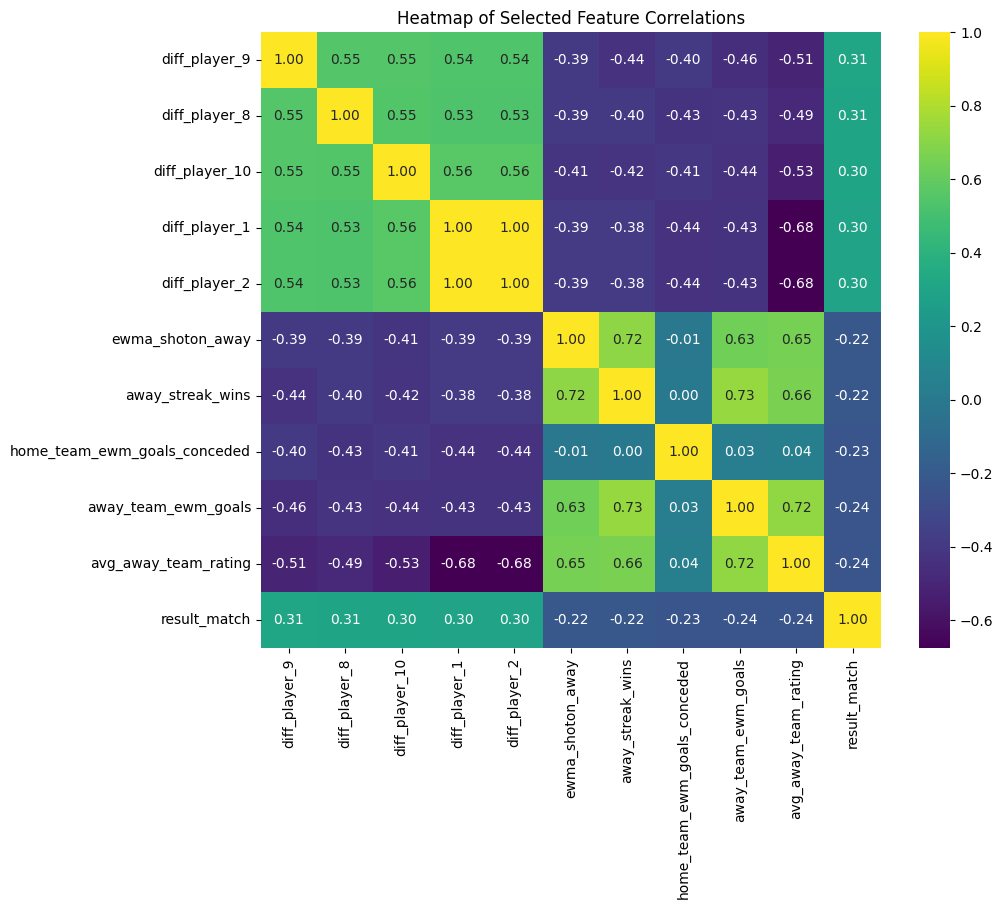

In [18]:
# Calculate the Pearson correlation matrix
correlation_matrix = df_with_rolling.corr()

# Extract the correlations with the target variable 'result_match'
correlations_with_target = correlation_matrix['result_match'].sort_values(ascending=False)

correlations_with_target

# Select the top 5 positively correlated and top 5 negatively correlated features (excluding the target itself)
top_positive_correlated_features = correlations_with_target.index[1:6].tolist()
top_negative_correlated_features = correlations_with_target.index[-5:].tolist()
selected_features = top_positive_correlated_features + top_negative_correlated_features

# Create a new dataframe with the selected features and the target variable
selected_data = df_with_rolling[selected_features + ['result_match']]

# Create a heatmap for the selected features
plt.figure(figsize=(10, 8))
sns.heatmap(selected_data.corr(), annot=True, fmt=".2f", cmap='viridis')
plt.title('Heatmap of Selected Feature Correlations')
plt.show()

In [19]:
df_ = df_with_rolling.copy()

In [20]:
away_players_7_11 = ['player_rating_away_player_6', 'player_rating_away_player_7', 'player_rating_away_player_8', 'player_rating_away_player_9', 'player_rating_away_player_10', 'player_rating_away_player_11']

df_['avg_away_rating_attack'] = df_[away_players_7_11].mean(axis=1).round(2)

home_players_7_11 = ['player_rating_home_player_6', 'player_rating_home_player_7', 'player_rating_home_player_8', 'player_rating_home_player_9',
            'player_rating_home_player_10', 'player_rating_home_player_11']

df_['avg_home_rating_attack'] = df_[home_players_7_11].mean(axis=1).round(2)

away_players_1_5 = ['player_rating_away_player_1', 'player_rating_away_player_2', 'player_rating_away_player_3',
            'player_rating_away_player_4', 'player_rating_away_player_5']

df_['avg_away_rating_defence'] = df_[away_players_1_5].mean(axis=1).round(2)

home_players_1_5 = ['player_rating_home_player_1', 'player_rating_home_player_2', 'player_rating_home_player_3',
            'player_rating_home_player_4', 'player_rating_home_player_5', 'player_rating_home_player_6']

df_['avg_home_rating_defence'] = df_[home_players_1_5].mean(axis=1).round(2)

In [21]:
df_['rating_difference'] = df_['avg_home_team_rating'] - df_['avg_away_team_rating']

In [22]:
df_['home_attack_defense_prowess'] = (df_['away_goals_rolling'] / df_['away_shots_on_rolling']) * (df_['home_goals_rolling'] / df_['home_shots_on_rolling'])
df_['away_attack_defense_prowess'] = (df_['home_goals_rolling'] / df_['home_shots_on_rolling']) * (df_['away_goals_rolling'] / df_['away_shots_on_rolling'])

df_['diff_attack_defence_power'] = df_['home_attack_defense_prowess'] - df_['away_attack_defense_prowess']
df_.drop(['home_attack_defense_prowess', 'away_attack_defense_prowess'], axis=1, inplace=True)

In [23]:
# Splitting the original dataset
X = df_.drop(['result_match'], axis=1)
y = df_['result_match']
X_train_full, X_test_full, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the XGBClassifier
xgb_full = XGBClassifier(random_state=42)

# Train the model on the full feature set
xgb_full.fit(X_train_full, y_train)

# Predictions and evaluation on the full feature set
y_pred_full = xgb_full.predict(X_test_full)
accuracy_full = f1_score(y_test, y_pred_full, average='weighted')

accuracy_full

0.49818297364082076

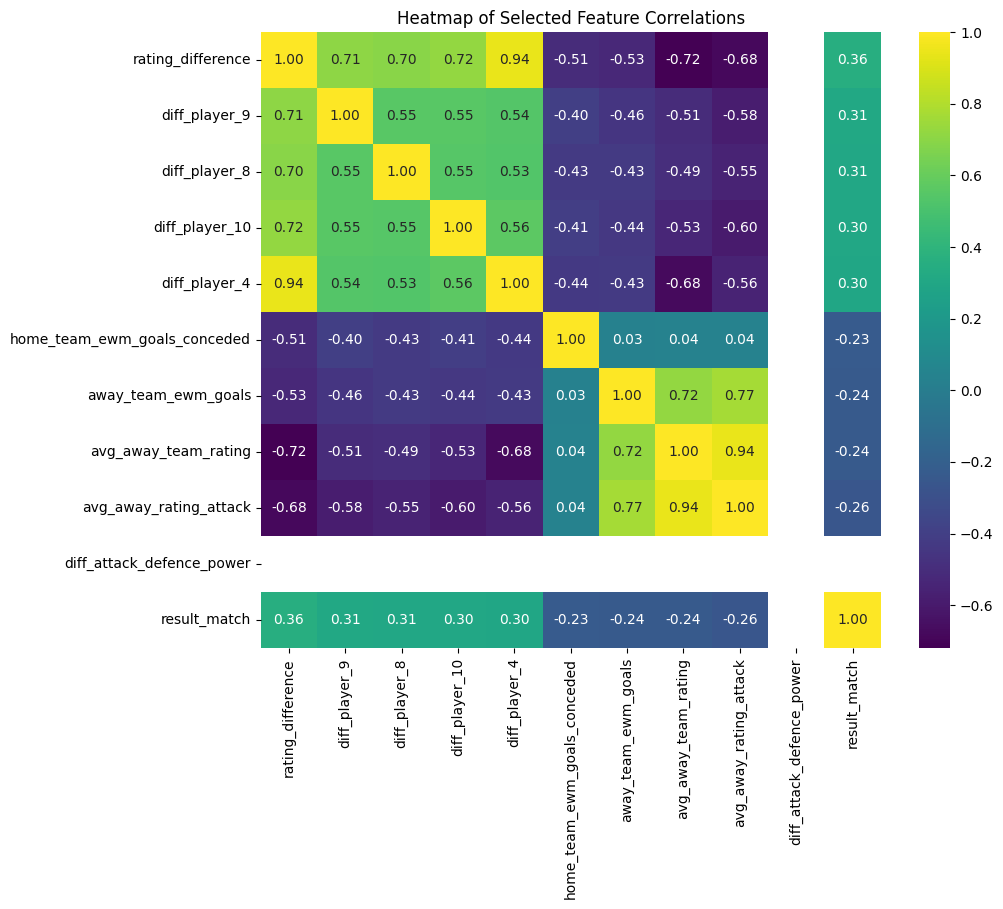

In [24]:
# Calculate the Pearson correlation matrix
correlation_matrix = df_.corr()

# Extract the correlations with the target variable 'result_match'
correlations_with_target = correlation_matrix['result_match'].sort_values(ascending=False)

correlations_with_target

# Select the top 5 positively correlated and top 5 negatively correlated features (excluding the target itself)
top_positive_correlated_features = correlations_with_target.index[1:6].tolist()
top_negative_correlated_features = correlations_with_target.index[-5:].tolist()
selected_features = top_positive_correlated_features + top_negative_correlated_features

# Create a new dataframe with the selected features and the target variable
selected_data = df_[selected_features + ['result_match']]

# Create a heatmap for the selected features
plt.figure(figsize=(10, 8))
sns.heatmap(selected_data.corr(), annot=True, fmt=".2f", cmap='viridis')
plt.title('Heatmap of Selected Feature Correlations')
plt.show()

In [25]:
import xgbfir

xgbfir.saveXgbFI(xgb_full, feature_names=X_train_full.columns, OutputXlsxFile='fir.xlsx')

file_path = 'fir.xlsx'
fir = pd.read_excel(file_path)

# Extracting top features based on different metrics
top_gain_features = fir.sort_values(by='Gain', ascending=False).head(10)
top_fscore_features = fir.sort_values(by='FScore', ascending=False).head(10)
top_wfscore_features = fir.sort_values(by='wFScore', ascending=False).head(10)
top_avg_gain_features = fir.sort_values(by='Average Gain', ascending=False).head(10)
top_expected_gain_features = fir.sort_values(by='Expected Gain', ascending=False).head(10)

# Displaying the top features
top_features_summary = {
    "Top Features by Gain": top_gain_features['Interaction'].values,
    "Top Features by FScore": top_fscore_features['Interaction'].values,
    "Top Features by wFScore": top_wfscore_features['Interaction'].values,
    "Top Features by Average Gain": top_avg_gain_features['Interaction'].values,
    "Top Features by Expected Gain": top_expected_gain_features['Interaction'].values
}

top_features_summary

{'Top Features by Gain': array(['rating_difference', 'ewma_shoton_away', 'away_shots_on_rolling',
        'ewma_shoton_home', 'home_team_ewm_goals_conceded',
        'away_team_ewm_goals', 'away_streak_wins', 'home_shots_on_rolling',
        'home_streak_wins', 'home_team_ewm_goals'], dtype=object),
 'Top Features by FScore': array(['away_shots_on_rolling', 'ewma_shoton_home',
        'home_shots_on_rolling', 'home_team_ewm_goals_conceded',
        'ewma_shoton_away', 'away_team_ewm_goals_conceded',
        'away_team_ewm_goals', 'home_team_ewm_goals', 'home_streak_wins',
        'away_streak_wins'], dtype=object),
 'Top Features by wFScore': array(['rating_difference', 'away_shots_on_rolling',
        'home_shots_on_rolling', 'avg_home_rating_attack',
        'ewma_shoton_home', 'away_streak_wins', 'away_team_ewm_goals',
        'away_team_ewm_goals_conceded', 'home_team_ewm_goals_conceded',
        'ewma_shoton_away'], dtype=object),
 'Top Features by Average Gain': array(['rating_di

In [26]:
# Load the data from the "Interaction Depth 1" and "Interaction Depth 2" sheets
interaction_depth_1 = pd.read_excel(file_path, sheet_name='Interaction Depth 1')
interaction_depth_2 = pd.read_excel(file_path, sheet_name='Interaction Depth 2')

# Display the first few rows of each sheet to understand their structure
interaction_depth_1_head = interaction_depth_1.sort_values('Average Gain', ascending=False).head(20)
interaction_depth_2_head = interaction_depth_2.sort_values('Average Gain', ascending=False).head(20)

interaction_depth_1_head

,Interaction,Gain,FScore,wFScore,Average wFScore,Average Gain,Expected Gain,Gain Rank,FScore Rank,wFScore Rank,Avg wFScore Rank,Avg Gain Rank,Expected Gain Rank,Average Rank,Average Tree Index,Average Tree Depth
0,ewma_shoton_away|rating_difference,278.735547,8,2.044333,0.255542,34.841943,131.110139,1,53,27,26,1,1,18.166667,22.125000,2.875000
1,ewma_shoton_home|rating_difference,268.486405,11,3.039668,0.276333,24.407855,86.987153,2,17,13,21,2,3,9.666667,21.272727,2.636364
3,player_rating_home_player_10|rating_difference,126.566950,6,1.623337,0.270556,21.094492,63.688037,4,81,36,23,3,5,25.333333,23.333333,2.666667
2,rating_difference|rating_difference,200.972545,12,6.467578,0.538965,16.747712,129.127313,3,9,2,4,4,2,4.000000,55.333333,3.166667
25,diff_player_9|rating_difference,47.170933,3,1.377632,0.459211,15.723644,28.324715,26,99,47,8,5,7,32.000000,19.000000,3.666667
12,home_team_ewm_goals|rating_difference,62.790575,4,0.705271,0.176318,15.697644,20.044555,13,96,74,43,6,12,40.666667,23.000000,2.500000
86,diff_player_1|player_rating_home_player_8,30.626219,2,0.294987,0.147494,15.313109,4.462909,87,100,95,54,7,71,69.000000,1.500000,3.000000
16,avg_away_rating_attack|ewma_shoton_away,59.699248,4,0.502027,0.125507,14.924812,11.611405,17,97,83,64,8,30,49.833333,19.000000,2.500000
4,avg_home_rating_attack|rating_difference,111.712036,10,6.521973,0.652197,11.171204,65.747525,5,25,1,1,9,4,7.500000,44.300000,3.200000
5,ewma_shoton_away|player_rating_home_player_8,106.653322,10,1.304856,0.130486,10.665332,22.008821,6,26,51,61,10,11,27.500000,39.800000,2.900000


In [27]:
interaction_depth_2_head

,Interaction,Gain,FScore,wFScore,Average wFScore,Average Gain,Expected Gain,Gain Rank,FScore Rank,wFScore Rank,Avg wFScore Rank,Avg Gain Rank,Expected Gain Rank,Average Rank,Average Tree Index,Average Tree Depth
4,avg_home_rating_attack|ewma_shoton_home|rating...,132.496314,1,0.084293,0.084293,132.496314,11.168481,5,75,79,61,1,21,40.333333,2.000000,2.000000
5,home_weighted_wins|rating_difference|rating_di...,131.912451,1,0.465872,0.465872,131.912451,61.454280,6,76,26,5,2,1,19.333333,2.000000,2.000000
1,away_team_ewm_goals|ewma_shoton_home|rating_di...,209.671859,2,0.531986,0.265993,104.835930,55.612740,2,38,21,21,3,2,14.500000,3.500000,2.000000
10,avg_home_rating_attack|player_rating_away_play...,88.585442,1,0.230263,0.230263,88.585442,20.397964,11,77,55,26,4,12,30.833333,0.000000,2.000000
3,avg_away_rating_attack|ewma_shoton_away|rating...,167.536011,2,0.446833,0.223417,83.768005,37.361441,4,39,27,27,5,5,17.833333,1.500000,2.000000
11,ewma_shoton_away|home_streak_wins|rating_diffe...,73.451434,1,0.390577,0.390577,73.451434,28.688464,12,78,33,8,6,8,24.166667,5.000000,2.000000
13,ewma_shoton_home|player_rating_away_player_11|...,71.000687,1,0.077284,0.077284,71.000687,5.487200,14,79,82,65,7,46,48.833333,5.000000,2.000000
15,avg_away_team_rating|player_rating_home_player...,58.931984,1,0.117268,0.117268,58.931984,6.910860,16,80,68,50,8,37,43.166667,3.000000,2.000000
2,away_team_ewm_goals|rating_difference|rating_d...,169.425204,3,0.330191,0.110064,56.475068,29.101691,3,16,42,56,9,7,22.166667,27.666667,2.666667
7,ewma_shoton_away|ewma_shoton_home|rating_diffe...,106.611411,2,0.532276,0.266138,53.305706,28.243960,8,40,20,20,10,9,17.833333,8.000000,2.000000


In [28]:
def create_interaction_features(data, interactions, depth):
    new_features = []
    for interaction in interactions:
        features = interaction.split('|')
        if len(features) == depth:
            # Creating a unique feature name
            new_feature_name = '_'.join(features) + '_interaction'
            new_features.append(new_feature_name)

            # Example operation: multiplying the features
            # This can be changed based on the nature of the features and the problem domain
            data[new_feature_name] = data[features].prod(axis=1)
    return data, new_features

In [29]:
# Extracting all interactions from both 'Interaction Depth 1' and 'Interaction Depth 2'
all_interactions_depth_1 = interaction_depth_1_head['Interaction']
all_interactions_depth_2 = interaction_depth_2_head['Interaction']

# Creating new features for all interactions in depth 1 and 2
data, new_features_all_depth_1 = create_interaction_features(df_, all_interactions_depth_1, 2)
data, new_features_all_depth_2 = create_interaction_features(df_, all_interactions_depth_2, 3)

# Displaying the number of new features created for each depth and the updated shape of the dataset
len(new_features_all_depth_1), len(new_features_all_depth_2), data.shape

(20, 20, (3040, 98))

In [30]:
from xgboost import XGBClassifier
from sklearn.metrics import f1_score
from sklearn.feature_selection import SelectFromModel

# Splitting the original dataset
X = data.drop(['result_match'], axis=1)
y = data['result_match']
X_train_full, X_test_full, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Initialize the XGBClassifier
xgb_full = XGBClassifier(random_state=42)

# Train the model on the full feature set
xgb_full.fit(X_train_full, y_train)

# Predictions and evaluation on the full feature set
y_pred_full = xgb_full.predict(X_test_full)
accuracy_full = f1_score(y_test, y_pred_full, average='weighted')
print(f"Accuracy with full feature set: {accuracy_full}")

# Extracting feature importance
feature_importances = xgb_full.feature_importances_

# Store results
results = []

# Select the most important features
thresholds = sorted(feature_importances, reverse=True)
for thresh in thresholds:
    # Select features using threshold
    selection = SelectFromModel(xgb_full, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train_full)

    # Train model
    selection_model = XGBClassifier(random_state=42)
    selection_model.fit(select_X_train, y_train)

    # Evaluate model
    select_X_test = selection.transform(X_test_full)
    y_pred = selection_model.predict(select_X_test)
    f1 = f1_score(y_test, y_pred, average='weighted')

    # Storing the results
    results.append({'threshold': thresh, 'n_features': select_X_train.shape[1], 'f1': f1})

# Sorting the results by accuracy
sorted_results = sorted(results, key=lambda x: x['f1'], reverse=True)

# Print the top 5 results
print("Top 5 feature selection results:")
for result in sorted_results[:5]:
    print(f"Threshold: {result['threshold']}, Number of Features: {result['n_features']}, F1: {result['f1']}")

# Sorting the results by F1 score and selecting the best one
best_result = max(results, key=lambda x: x['f1'])

# Extracting the best feature names
selection = SelectFromModel(xgb_full, threshold=best_result['threshold'], prefit=True)
best_features = X_train_full.columns[selection.get_support()]

# best_features now contains the names of the best set of features
# print(f"Best Feature Set: {list(best_features)}")

Accuracy with full feature set: 0.506928650487307
Top 5 feature selection results:
Threshold: 0.010257534682750702, Number of Features: 38, F1: 0.5329124249890244
Threshold: 0.01050681434571743, Number of Features: 30, F1: 0.527470990661813
Threshold: 0.008473766036331654, Number of Features: 70, F1: 0.5261737585955881
Threshold: 0.010369431227445602, Number of Features: 34, F1: 0.524860621620854
Threshold: 0.007571639958769083, Number of Features: 76, F1: 0.5210044562712355


In [31]:
import os

output_dir = "../data/transform/"
filename= "df_engineered.csv"

full_path = os.path.join(output_dir, filename)
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

data[best_features].to_csv(full_path, index=False)